<table class="table table-bordered">
    <tr>
        <th style="text-align:center; width:25%"><img src='https://www.np.edu.sg/PublishingImages/Pages/default/odp/ICT.jpg' style="width: 250px; height: 125px; "></th>
        <th style="text-align:center;"><h1>Deep Learning</h1><h2>Assignment 2 (Problem 1) - Sentiment Analysis Model  (Group)</h2><h3>AY2022/23 Semester</h3></th>
    </tr>
</table>

In [8]:
# Import the Required Packages
import spacy
from spacy_langdetect import LanguageDetector
from googletrans import Translator
from langdetect import detect
from textblob import TextBlob
import string
import numpy as np
import re
import pandas as pd
import os
import sys
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import SimpleRNN, Embedding, Dense, Dropout, LSTM, GRU, Flatten, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from emot.emo_unicode import UNICODE_EMOJI, EMOTICONS_EMO
import nltk
from nltk.corpus import stopwords
%matplotlib inline
from tensorflow.keras.layers import Embedding, GRU




## Step 1 – Data Loading and Processing (Group)

### 1.1 Data Loading

In [9]:
## Open and read file

base_dir="C:\Year 2\DL\Assignment\Assignment 2"
filename = "templerun_reviews.csv"
path_to_file = os.path.join(base_dir, filename)
df = pd.read_csv(filename)
print(df.shape)
print(df.info())


(40000, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              40000 non-null  object
 1   userName              40000 non-null  object
 2   userImage             40000 non-null  object
 3   content               40000 non-null  object
 4   score                 40000 non-null  int64 
 5   thumbsUpCount         40000 non-null  int64 
 6   reviewCreatedVersion  8121 non-null   object
 7   at                    40000 non-null  object
 8   replyContent          17 non-null     object
 9   repliedAt             17 non-null     object
dtypes: int64(2), object(8)
memory usage: 3.1+ MB
None


In [10]:
# Ensuring each value has 8000 reviews
# Balanced dataset ensures machine learns fairly and will not be biased to any values

df['score'].value_counts()

1    8000
2    8000
3    8000
4    8000
5    8000
Name: score, dtype: int64

In [11]:
## Converting emojis & removing emoticons

# Step 1: Replace emoji with relevant word it represents
def convert_emojis(text):
    for emot in UNICODE_EMOJI:
        text = text.replace(emot, "_".join(UNICODE_EMOJI[emot].replace("_","").replace(":"," ").replace(",","").split("_")))
    return text

with open('Emoticon_Dict.p', 'rb') as fp:
    Emoticon_Dict = pickle.load(fp)

def remove_emoticons(text):
    emoticon_pattern = re.compile(u'(' + u'|'.join(k for k in Emoticon_Dict) + u')')
    return emoticon_pattern.sub(r'', text)

In [12]:
# Converting df reviews to list and applying the functions

# Removing emoticons because they are uncommon and could confuse the machine (low sample size)
# Converting emojis because they are common and will help with the context and prediction of the review

reviews_list = df['content'].tolist()
reviews_list_c = []
for review in reviews_list:
    processing = convert_emojis(review)
    final = remove_emoticons(processing)
    reviews_list_c.append(final)


In [17]:
# Testing if the functions are working as intended

test_emoji  = "wow😀hi"
test_emoji = convert_emojis(test_emoji)

test_emoticon = "This is a :^)hi"
test_emoticon = remove_emoticons(test_emoticon)

print(test_emoji)
print(test_emoticon)

wow grinningface hi
This is a hi


In [18]:
# Ensuring reviews_list_c is in the correct shape and ensuring that all emojis are converted

print(len(reviews_list_c))
for review in reviews_list_c:
    print(review)

40000
Thanks again
Good Game
This is a super game
F***ing game
Very good morning  baby   girl 
Nice game
Good
This is a very bad game because the Graphics and design are very bad  thumbsdown   neutralface   facewithsymbolsonmouth  poutingface  yawningface  frowningface  facevomiting  sneezingface  upside-downface 
JaHaN
I'll give it 1 star because my game isn't downloading and saying see the common ways to fix the problem send feedback so I sent the feedback to you. Please fix this problem. Thanks
Goodgame
Juu
গেম দাওবহুৎ ভালো
Worst game
Very good game for temple run
Yes i am in
Tample run is a best runner game
This is worst app ,Don't play it
Jack.oredo
SamiuL
হেদা
Have a good games
It is fun
Don't download this app can't control .
Great  OKhand  OKhand  OKhand  OKhand 
When you die it will ask "watch ad to continue or no" even if you press no it will show you ad before going to home page
Yes Like Fac
ছ ড মভ
So great and very good it's just so fun you can relax playing it so try it re

Updated it
Dodn
Mmmmmm Uuuuu
It is the worst game ever  unamusedface   facewithsteamfromnose   expressionlessface   sleepyface   tiredface 
Akash chauhan RAJ
Its not installed such a blady game
 yarn 
Very nice game
Jeba
Kana jaat
Fazool
fd
I don't like this game
Very nice game
Too many ads
,  expressionlessface 
Gydgu
Too many ads rn, it was fun back then
Nice
Wow best app thanks. You so much free fire bhi bohut acha hai or Mera land bhi acha hai
ධර්ම 2
7 winkingface  angryface  facewithtearsofjoy 
Anik
Bzg
Good
very poor
It's not good hahhhaa
Hello pael
Nice
Hhduriegi
আমার ইউটিউব চ্যানেল সাবস্ক্রাইব করবেন মুনতাজ বন্ধু মিডিয়া
বি
Henrymwanza
Bakit kong maka sabi kayo ng walang lag akala niyo naman online game to? Hindi naman to online game diba? Mga tangek Pasinsiyana kong Tagalog di kasi ako magaling sa English HAHAHA
Philomin dubsmash badgering surendran evergreen for you and you may contact them at that it doesn't want them up so sorry this week so you would prefer tamil by using t

Very bad
 expressionlessface  expressionlessface 
Temple. Run
නුවන්
av cable and pay it off and put the rest
Such a great game
Not best
Raful
Good game but my phone stuck for this game and i delete the game
Oo good
I am boss
Telugu Though Telugu @ L.A. Hi daddy
nice .
Shweta
I Like this game .......  huggingface  huggingface  huggingface 
Bad
Supper
Bakvas game
S.S uriya uirga man 
best this game
 ox  tigerface  lion  lion  lion  lion  Austria  Anguilla  Albania  Albania  Albania 
Very poor game
Its not insatall
I like it but his noting down loud im so sad disappointedface  disappointedface  disappointedface 
Nikhil kumar
Riya
PlzZz help....MeRi game m prblem ho Ri hai hai... Or us m error code 2500 LikHa a Ra hai downcastfacewithsweat  downcastfacewithsweat  downcastfacewithsweat  downcastfacewithsweat  downcastfacewithsweat  downcastfacewithsweat 
Arman. Malik
Khatiya
Mn 29
Worst temple run ever
Ankitgond I lounge
nice very very nice  smilingfacewithheart-eyes  smilingfacewithheart-e

best game  thumbsup  thumbsup  thumbsup  thumbsup 
You are game is nice
I don't rate because the adds em em
So sweet game
Mehadi
I like this game very nice game OKhand  OKhand  OKhand  OKhand  OKhand  OKhand  OKhand  OKhand  signofthehorns  signofthehorns  signofthehorns  signofthehorns  callmehand  callmehand  callmehand 
Saniyaro
Nice ekta games
Arfan
Aoshi Roy
KiSH. KUMAR
 nauseatedface  nauseatedface  nauseatedface  nauseatedface  nauseatedface  nauseatedface  nauseatedface  nauseatedface  nauseatedface  nauseatedface  nauseatedface  nauseatedface  nauseatedface  nauseatedface  nauseatedface  nauseatedface  nauseatedface  nauseatedface  nauseatedface  nauseatedface  nauseatedface  nauseatedface  facevomiting  facevomiting  facevomiting  facevomiting  facevomiting  facevomiting  facevomiting  facevomiting  facevomiting  facevomiting  facevomiting  facevomiting  facevomiting  facevomiting  facevomiting  facevomiting  facevomiting  facevomiting  lyingface  facevomiting  poutingface  p

Yyy^
Nice game
Good game but boring
This game is amazing
Super
Good Game
This is a not a good game this is so boring
Good
Imaran foldedhands  foldedhands 
Hi November
Good
Good game  smilingfacewithsunglasses  I like it
Super
 confusedface  winkingface  grimacingface / ("¥*
I love this game
Not bad grafics and quality average
Not that fun I deleted it at the first day
Anuf
It's not good
It always say the app has stopped but i love this game there are so many ads it makes me want to delete this app
I really love this game.It relax my mind after a day of hard work.
Very good game
Niiice
So good
Gujjar
নমেয়া দেণ
There is some problem in the game's sound . But it's a good game.
IT'S NICE!
Download games to play
Best game and water what
Good
Wow it so nice game
Fyi
thisapp
អាច អដ្ឋករ ថ្លង់ ្ហដចដ ថ កង ហងរហ, យដ
Too much adds
Ganda Temple Run
Bahot ezzy
Good
Worst game ever made
 victoryhand  victoryhand 
Simply nice game
Sami But g
Divtansh
Kira and make
 Taurus  redcircle  redcircle  redcirc

Wow
Dj Alok
Nice
dd
Subodh
Nagbigay ako ng dalawang tao kasi ang ganda ng game
MST yo
Satyam  woman ‍ woman ‍ boy  woman ‍ familywomangirl  familymangirl ‍ girl  familymangirl  palmsuptogether  smilingfacewithsmilingeyes  facewithtongue  facesavoringfood  facesavoringfood  upside-downface  facewithtongue  confoundedface  facewiththermometer  poutingface  poutingface  angryface  facewithmedicalmask  facewithmedicalmask 
Better is temple run² . can't save in cloud
J3eez I hate this game
Ajith
The best
Nice game
Nice
Support
Simple game
I like the game but temple run 2 is 101 m.b cryingface  pensiveface   oldwoman  princess  personwithveil 
The game is the best thing that has ever happened to methe game is good for you
5years ago i have been playing this game. It was nice then also now also
This game is to ugly ugh facewithrollingeyes  clownface 
aban Khan Rider
Ui
Happy
Abhishek
Good and interesting game
Good
I like this game and this game is very very interesting .
1st fathan bro
Very g

Go
Good
爱
Install
Riya Singh Rajput
But i want rope at first itself pls
Tempted
Is a good game
I  smilingfacewithsmilingeyes 
jitu
Super
Super game
Good
Bad
It's a challenging game but I enjoy it
Love the game only that it freezes up
Good
I love it
@nooob ajay the gamer}
Bad game
Its very bad game facewithraisedeyebrow  facewithraisedeyebrow 
Bad
I love temple run super
Good game, but too many ads
It is bad even when you buy a girl it can't stay Moses
Bad
yt
 India  star-struck  star-struck  smilingfacewithhearts 
Almost ok
Templerunq
Mass
Good  slightlysmilingface  slightlysmilingface  slightlysmilingface  slightlysmilingface  slightlysmilingface  slightlysmilingface  slightlysmilingface  slightlysmilingface  slightlysmilingface  smilingfacewithheart-eyes  smilingfacewithsunglasses  faceblowingakiss 
It was to good game
Great
Temple run2
Templerun
Templepuh
Better .. but not good it will be boring . And irritate that ...
 thumbsup  thumbsup 
This is a local game all rubbish peoples pl

Need new characters
what a game
game
templerun
ameyzing supperameyzing
more add
I love this game
graphics u should improve
this game is very interesting i like this game
fair
nice game good graphics, controls
too many adds... just annoying confoundedface 
i dont like it at all just being honest
perfect
nice game and easy to play
avgg
damini chaudhari
tempullran geym send
cgf
t free r too long so wasn't udbf in
An ad after every single run..? Wow.
itempal run
need imrove like oz and 3
but
wandering game
what a midi dirty worst forest
first of all,this game is not what it used to be I miss a lot. and u made the graphics worse!WHO WOULD DO THAT LOL
to many ads
Good
Excellent
Yyuy
Really good game and easily oprate
Meaning of ads
 Indonesia 
Safras
 thumbsup  grinningface wow
Good ........ ............. ............ ............... ......... ............. . ............... ........... ................ .............. . ............. ................... ................... ............... ..

super
Everything is fine but i have to disable my internet everytime i play this game because of the ads.
Thoda acha hai
Superb
I  redheart  this app but yet given 3 star because whenever I lost then he stuck there
Kiran Kiran
Fig
This is a very adventurous game
Nice game ..but sound on off ki koi prosess nahi hya..
 OKhand  OKhand  OKhand 
M3almi  kissingfacewithclosedeyes  kissingfacewithsmilingeyes  heartsuit ️ hundredpoints  fire  collision  star-struck  huggingface  faceblowingakiss  kissingfacewithclosedeyes 
Many ads that's all the problem facewithrollingeyes 
nice game
Good
..ò0
ഇത് ഈസ്‌ ഗുഡ് ഗെയിം
Sjo
It is so nice game
Salvin
Good
Open
Very nice
No words to say ...
Ppoooo
I can't go last every time I loss
 upside-downface  grinningfacewithsweat  grinningfacewithsweat  grinningfacewithsweat  grinningfacewithsweat  grinningfacewithsweat  grinningfacewithsweat  grinningfacewithsweat  grinningsquintingface  grinningfacewithsweat  grinningfacewithsweat  grinningfacewithsweat  grin

Nice
This game sucks but doesint
TemDle Run
I very love the app Temble run!! faceblowingakiss  faceblowingakiss  But its so hard  pensiveface  pensiveface  Thankyouu grinningfacewithsmilingeyes  grinningfacewithsmilingeyes 
Good
Happy birthday o
So lame. I thought it would be like temple run 2
Nice game
Good game i Iike it
Atleast something i can rest my brain onto.
I'm very interested in this game
Good
Templerun
It is varey super
Good
TempleRun
It's a fantastic game...
Amyzing game for time pass
Rqz  grinningfacewithsweat  smilingfacewithhorns  grinningfacewithsmilingeyes  lipstick  runningshoe  tophat  woman’shat  crown  necktie  watch  glasses  lipstick  Japanesesymbolforbeginner  kimono  woman’sclothes  woman’sboot  woman’sboot  woman’sboot  moneybag  heavydollarsign  heavydollarsign  woman’sclothes  creditcard  woman’sboot  backpack 
The game is not bad but I've played better
Nice
Nice
This game is just to time pass huh! boring
Super game
Not that good it freezes alot but its nice

Nice game
i love this game becuses it is an amazing and wonderfull game
Irfanali
This game is nice but it contains lots of ads and i am sick of this
S k
Good
Time pass k liye accha h
Aa yhu
Temple run 2
Ruchirana
I want the temple run 2 old version not new version
It's good
Having more fun
Thats a nice game
Am enjoyng
123  star-struck  star-struck  star-struck  star-struck  star-struck  star-struck  star-struck  star-struck  star-struck  star-struck  smilingfacewithsunglasses  smilingfacewithsunglasses  star-struck  star-struck  star-struck  star-struck  star-struck  star-struck  star-struck  redheart  redheart  redheart  redheart  redheart  mushroom  mushroom  mushroom 
Bjl
Golu kumar singh
Good
 grinningface  grinningface  grinningface 
Where is my brother brain man I have old chicken on my head why?
Wow
Nice game
This game is amaze for me and had a little bet intence and scared
Nice game it's awesome
I like this game
I like this game too much but I give only 3 stars on this rate
A  

Hii L
Fascinating
 grinningfacewithsmilingeyes  grinningfacewithsmilingeyes  grinningfacewithsmilingeyes  grinningfacewithsmilingeyes  grinningfacewithsmilingeyes  grinningfacewithsmilingeyes  grinningfacewithsmilingeyes  grinningfacewithsmilingeyes  grinningfacewithsmilingeyes  grinningfacewithsmilingeyes  grinningfacewithsmilingeyes  grinningfacewithsmilingeyes  grinningfacewithsmilingeyes 
Fun
Temple Run i love you  faceblowingakiss  heartwithribbon 
I Like it it should not change thumbsup  OKhand And it is for every age
This game is awesome
Nhi 12345678
Good
It's a good game
ANU
Nice game
This game is wow!
Uxhs
It is interesting and fun.
is nice gam
This is a very challenging and risky game but out of all of it it is quite fun and all you have to do is run until the ending but the bad part of this game is it has a lot of ads
It's not better working in playing.
Sk.poonam.jafrin
This game is amazing. I like this game you like than more gift  wrappedgift  than you play now please?
Lll

Yes this is nice game
good and good
Like it
Hi sir this game is very Good and and Thankful tu You
Good
This game are very well I liket this game
The game was okay
සකුන්ත
I can say only that this is oseum
Its about running for life
Hasmatsk123
Nice game
Superb
Itz ok
i like this game my sis make this game high score
Ok it's fine
I  smilingfacewithheart-eyes  LOVE THIS GAME
nice hone
Awesome
It is very interesting game
This game is my childhood and it is still soo amazing
This is good I like it very much please download this game this is very very good
Good game
Nice  videogame 
I like this game very much it's interesting
To jfk it's
Yash
I like this game most people would be great game
Daagu
Prashsnt
Vikas
Wow
So sweet an SSSOOO Many thanks for the first time since we have so much and Gart the size and shape of po pooo9o of the size and shape and art appreciators alosfbsphz hsvibsvfogshp hhsvyrry vafjbksvFree  fire 
Good
My,names,naiar
Nut smilingfacewithsunglasses  facewithtearsofjoy 🖒

Beautiful game I had play alot of time bakcvadv
This game is very nice very adventurous game because every thing going fast and I like becise there no ads in it .so I give only 4 starts .
Power full
Superb
Nooooooooooooo way this is great
Kk ...
Good
It is nice game I like this game It so easy
Good luck
Who ever made this thank you for this app and i really pike it for shore so thank you very much*From:Armaen To:Temple Run
Best game in running
I rate this game 4 star because all its sounds, actions and effects are clearly ellaborated in the game
This is best game
Very nice game to play exept it has lots of adds like after each level otherwise it is a amazing game to play .
Good
surely super
I love this game ....at every moment we get a new chance to win and this make me excited . So frnds please play once time ....and enjoy it ...........
I like this game .it is very funny
This game is very good and very funny I am enjoying very well as long time
Nyc game
Very good but too much ads.
Ni

My favourite game  videogame 
Good
Very interesting game
Super
Ýahiýà
Its so fun smilingfacewithsmilingeyes 
I love temple run
Nice gam
Pretty nostalgic y'all are very amazing
 winkingfacewithtongue 
This game is fantastic ads there but no problem best game for me
My fvrt game smilingfacewithheart-eyes 
Perfect, I'm happy that after all these years nothing has changed!
Old is gold
this game is very good i use this game huggingface  huggingface 
খুবই ভালো এই গেমটা সুন্দর ভেরি বেআউটিফুল
The problem is that if I want temple run 2 you give me 10 years I dont like it
Thank you redheart 
Good
Love this game
 thumbsup  thumbsup  thumbsup  i like
Mast game gise
বুুধ .
game you are play
Wowwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwww
It's good i like it
Still great game
I Love  faceblowingakiss  this  smilingfacewithheart-eyes  game  purpleheart  revolvinghearts  purpleheart  revolvinghearts 
Very. Excellent. Game soccerball  grinningface 
Super game it's very good game
Vereey goad
 fac

Ok good
Good geme
Sahil
Nice app
I like this game
 faceblowingakiss  faceblowingakiss 
This game is very adventures game I like this game very much
It's amazing this is a best game and I love it
Temple run is based on true story there was a guy killed the child's monster so the monster got angry try to get reveng
B.damayanthi
VERY MUCH AND I WILL SEND IT TO
It's best game ever
Harsha Vardhan
Ravikisan kumar
This game is I liket
rye whiskey in the place is so sweet
This is the game which we play a lot of times because in this game we feel the change of environments in a adventures mode.
No WiFi y Suresh did slavish hx
Utut
This is a fast moving game where you need to think ahead of yourself. Once you get the hang of it, it can keep you coming back again and again trying to beat your last score. It has been a long while since I played this game, so I'm a little unsure of the game play now. I hope it hasn't changed much as what they had was absolutely first class ☆☆☆
Love dis game, beamin

Nice
Good game
Faltu
ganda
It is very good and so beautiful game i will play seriously and enjoy this game
Best game is so nice I like this game so nice  sparklingheart  sparklingheart  sparklingheart  sparklingheart  smilingfacewithsmilingeyes  smilingfacewithsmilingeyes  smilingfacewithsmilingeyes  smilingfacewithsmilingeyes 
This is an amazing game..gets rid of the boredom just like that smilingface  smilingface 
It is a good game
Op
Cobra hay tample runs
Good game ,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Nice app
Very nice
Good
Super  OKhan

In [19]:
# Replace old column content with reviews_list_c content
print(df.columns[3])

# We see that content col is at index 3

reviews_list_c_pd = pd.DataFrame(reviews_list_c)

df['content'] = reviews_list_c_pd

content


In [20]:
def isEnglish(s):
  check = s.isascii()
  if check:
    lang = "en"
  else:
    lang = "nan"
  return lang

df['lang'] = df['content'].apply(isEnglish)

In [21]:
print(df['lang'].value_counts())

en     37967
nan     2033
Name: lang, dtype: int64


In [22]:
df.drop(df.index[df['lang'] == "nan"], inplace=True)
df.shape

(37967, 11)

In [23]:
## Up to here, 

# 1. Df is up to date
# 2. reviews_list_c is a list of the updated reviews (no emoticons, converted emojis)
# 3. reviews_list_c_pd is the df of reviews_list_c

In [24]:
# Next: Check and Remove reviews with no content

checker = []
for i  in range(len(reviews_list_c)):
    if reviews_list_c[i] == '':
        checker.append(i)
print(len(reviews_list_c))
print(checker)


40000
[10264, 24803]


In [25]:

# Removing these reviews

print(df['content'][10264] == "")
print(df['content'][24803] == "")

df = df.drop(10264)
df = df.drop(24803)

df = df.reset_index(drop=True)
df.tail()

True
True


,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,lang
37960,68b9a659-b3ec-4c4c-9bce-b60a74f24a30,Ganesh Hero,https://play-lh.googleusercontent.com/a/AItbvm...,Ganesh Her o,5,0,NaN,2022-03-26 17:55:32,NaN,NaN,en
37961,8be38fa5-c5b5-4637-865d-58689b438bb0,Ify Nwokocha,https://play-lh.googleusercontent.com/a/AItbvm...,Its because it is wonderful,5,0,1.19.3,2022-03-26 17:52:44,NaN,NaN,en
37962,a9910882-4d4a-44f5-ab29-46f566f74b2c,Qiearra Althea,https://play-lh.googleusercontent.com/a-/AFdZu...,Favorite game as a kid,5,0,NaN,2022-03-26 17:50:20,NaN,NaN,en
37963,3ee1148e-f447-4c44-ad17-5f0b3d3f3ec1,Insha Fatima,https://play-lh.googleusercontent.com/a/AItbvm...,Best game for ever milkyway,5,0,NaN,2022-03-26 17:34:54,NaN,NaN,en
37964,6e09cc4b-acf4-4935-adb1-979c732d6538,Durai Ramasamy,https://play-lh.googleusercontent.com/a/AItbvm...,Nice,5,0,NaN,2022-03-26 17:32:55,NaN,NaN,en


In [26]:
# Checking to ensure those rows have been deleted

print(df.shape)
test = df['content'].tolist()
checker = []
for i in range(len(test)):
    if test[i] == "":
        checker.append(i)
print(checker)

(37965, 11)
[]


In [27]:
# Cleaning the text. Lowercasing all words and taking away tags

def clean_text(text):
    
    text=re.sub("</?.*?>"," <> ",text)
    
    text = "".join([word.lower() for word in text if word not in string.punctuation])

    return text

df['content_clean'] = df['content'].apply(lambda x:clean_text(x))

In [28]:
df['content_clean']

0                           thanks again
1                              good game
2                   this is a super game
3                              fing game
4        very good morning  baby   girl 
                      ...               
37960                       ganesh her o
37961        its because it is wonderful
37962             favorite game as a kid
37963       best game for ever milkyway 
37964                               nice
Name: content_clean, Length: 37965, dtype: object

In [29]:
## Tokenize text. Allows us to remove stopwords and lemmatize text
## This allows model to learn more efficiently

def tokenize(text):
    tokens = re.split('\W+', text)
    return tokens

df['content_tokenized'] = df['content_clean'].apply(lambda x: tokenize(x))
df['content_tokenized']

0                            [thanks, again]
1                               [good, game]
2                 [this, is, a, super, game]
3                               [fing, game]
4        [very, good, morning, baby, girl, ]
                        ...                 
37960                       [ganesh, her, o]
37961      [its, because, it, is, wonderful]
37962           [favorite, game, as, a, kid]
37963    [best, game, for, ever, milkyway, ]
37964                                 [nice]
Name: content_tokenized, Length: 37965, dtype: object

In [30]:
# Removing stopwords. These words play no role in determining the sentiment of the review. E.g. "it", "has"
import nltk
nltk.download('stopwords')
def remove_stopwords(text):
    for word in text:
        if word in stopwords.words('english'):
            text.remove(word)
    return text

df['content_no_stopwords'] = df['content_tokenized'].apply(lambda x:remove_stopwords(x))
df['content_no_stopwords']

[nltk_data] Downloading package stopwords to C:\Users\Cheng
[nltk_data]     Jhang\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


0                              [thanks]
1                          [good, game]
2                     [is, super, game]
3                          [fing, game]
4         [good, morning, baby, girl, ]
                      ...              
37960                       [ganesh, o]
37961          [because, is, wonderful]
37962          [favorite, game, a, kid]
37963    [best, game, ever, milkyway, ]
37964                            [nice]
Name: content_no_stopwords, Length: 37965, dtype: object

In [31]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
wn = nltk.WordNetLemmatizer()
def lemmatizing(text):
    text = [wn.lemmatize(word) for word in text]
    return text

df['content_lemmatized'] = df['content_no_stopwords'].apply(lambda x: lemmatizing(x))
df['content_lemmatized']

[nltk_data] Downloading package wordnet to C:\Users\Cheng
[nltk_data]     Jhang\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\Cheng
[nltk_data]     Jhang\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


0                              [thanks]
1                          [good, game]
2                     [is, super, game]
3                          [fing, game]
4         [good, morning, baby, girl, ]
                      ...              
37960                       [ganesh, o]
37961          [because, is, wonderful]
37962          [favorite, game, a, kid]
37963    [best, game, ever, milkyway, ]
37964                            [nice]
Name: content_lemmatized, Length: 37965, dtype: object

In [32]:
def join_words(text):
    text = " ".join(text)
    return text

df['content_final'] = df['content_lemmatized'].apply(lambda x: join_words(x))
df['content_final']

0                          thanks
1                       good game
2                   is super game
3                       fing game
4         good morning baby girl 
                   ...           
37960                    ganesh o
37961        because is wonderful
37962         favorite game a kid
37963    best game ever milkyway 
37964                        nice
Name: content_final, Length: 37965, dtype: object

In [33]:
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,lang,content_clean,content_tokenized,content_no_stopwords,content_lemmatized,content_final
0,1d0dcad7-c26c-4f4d-bbae-5361ec043402,ZAINAB FIAZ,https://play-lh.googleusercontent.com/a/AItbvm...,Thanks again,1,0,NaN,2022-07-15 03:28:54,NaN,NaN,en,thanks again,[thanks],[thanks],[thanks],thanks
1,d516356d-0089-4761-809f-cd2796384549,Tab1141 Pdpl,https://play-lh.googleusercontent.com/a/AItbvm...,Good Game,1,0,NaN,2022-07-15 00:20:00,NaN,NaN,en,good game,"[good, game]","[good, game]","[good, game]",good game
2,46e92694-1742-4a44-9e07-21e29416fffd,Vyga Mahesh,https://play-lh.googleusercontent.com/a/AItbvm...,This is a super game,1,0,NaN,2022-07-14 23:18:52,NaN,NaN,en,this is a super game,"[is, super, game]","[is, super, game]","[is, super, game]",is super game
3,182fb889-c1d7-4a54-8bc4-76d083937459,melan Kaweeshwara,https://play-lh.googleusercontent.com/a/AItbvm...,F***ing game,1,0,1.19.3,2022-07-14 21:43:48,NaN,NaN,en,fing game,"[fing, game]","[fing, game]","[fing, game]",fing game
4,9b839e7b-0fc2-4ba6-87ac-0c99e3906772,Ravi Shinde,https://play-lh.googleusercontent.com/a/AItbvm...,Very good morning baby girl,1,0,NaN,2022-07-14 17:01:42,NaN,NaN,en,very good morning baby girl,"[good, morning, baby, girl, ]","[good, morning, baby, girl, ]","[good, morning, baby, girl, ]",good morning baby girl


In [34]:
def minus(score):
    score-=1
    return score
df['score'] = df['score'].apply(lambda x:minus(x))
df['score'].value_counts()

2    7643
3    7615
1    7613
0    7570
4    7524
Name: score, dtype: int64

In [35]:
templerun_dataset = df[["content_final","score"]]
templerun_dataset.to_csv("templerun_dataset.csv", index=False)

In [36]:
# Param for tokenizing and padding

col_content_final = df['content_final'].tolist()
col_score = df['score'].tolist()

vocab_size = 15000
embedding_dim = 64
max_length = 70
padding_type = 'pre'
trunc_type='pre' # Human nature to express true feelings towards the end of a review
oov_tok = "<OOV>"

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(col_content_final)
word_index = tokenizer.word_index

##training sequences and labels
train_seqs = tokenizer.texts_to_sequences(col_content_final)
padding=padding_type
train_padded = pad_sequences(train_seqs,maxlen=max_length, truncating=trunc_type)

In [37]:
print(word_index)

{'<OOV>': 1, 'game': 2, 'good': 3, 'nice': 4, 'is': 5, 'like': 6, 'the': 7, 'thumbsup': 8, 'love': 9, 'i': 10, 'run': 11, 'very': 12, 'ad': 13, 'a': 14, 'okhand': 15, 'temple': 16, 'super': 17, 'best': 18, 'it': 19, 'smilingfacewithhearteyes': 20, 'bad': 21, 'play': 22, 'app': 23, 'smilingfacewithsmilingeyes': 24, 'time': 25, 'star': 26, 'much': 27, 'this': 28, 'so': 29, 'faceblowingakiss': 30, 'fun': 31, 'not': 32, 'redheart': 33, 'amazing': 34, 'really': 35, 'ok': 36, 'beamingfacewithsmilingeyes': 37, 'you': 38, 'thumbsdown': 39, 'many': 40, 'one': 41, 'great': 42, 'dont': 43, 'my': 44, 'please': 45, 'give': 46, 'poutingface': 47, 'add': 48, 'to': 49, 'have': 50, 'smilingfacewithsunglasses': 51, 'interesting': 52, 'playing': 53, 'grinningface': 54, 'wow': 55, 'facewithtearsofjoy': 56, 'wa': 57, 'smilingfacewithhalo': 58, 'u': 59, 'get': 60, 'download': 61, 'am': 62, 'old': 63, 'better': 64, 'awesome': 65, 'hai': 66, 'boring': 67, 'videogame': 68, '2': 69, 'be': 70, 'cool': 71, 'sligh

In [38]:
print(len(word_index))

19245


In [39]:
print(train_padded)
print(len(train_padded))

[[   0    0    0 ...    0    0  143]
 [   0    0    0 ...    0    3    2]
 [   0    0    0 ...    5   17    2]
 ...
 [   0    0    0 ...    2   14  202]
 [   0    0    0 ...    2   79 5602]
 [   0    0    0 ...    0    0    4]]
37965


### 1.3 Data Sampling

In [40]:
def minus(score):
    score-=1 
    return score
df['score'] = df['score'].apply(lambda x:minus(x))
df['score'].value_counts()

 1    7643
 2    7615
 0    7613
-1    7570
 3    7524
Name: score, dtype: int64

In [41]:
X = train_padded
y = df['score'].tolist()

# Split the dataframe into train and test set with a 80:20 ratio respectively

X_train, X_test, y_train, y_test = train_test_split(train_padded, y, test_size=0.2, random_state=42)

In [42]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.asarray(y_train).astype('float32')
y_test = np.asarray(y_test).astype('float32')

In [43]:
print(X_train.shape)
print(X_test.shape)

print(y_train.shape)
print(y_test.shape)

(30372, 70)
(7593, 70)
(30372,)
(7593,)


In [44]:
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,lang,content_clean,content_tokenized,content_no_stopwords,content_lemmatized,content_final
0,1d0dcad7-c26c-4f4d-bbae-5361ec043402,ZAINAB FIAZ,https://play-lh.googleusercontent.com/a/AItbvm...,Thanks again,-1,0,NaN,2022-07-15 03:28:54,NaN,NaN,en,thanks again,[thanks],[thanks],[thanks],thanks
1,d516356d-0089-4761-809f-cd2796384549,Tab1141 Pdpl,https://play-lh.googleusercontent.com/a/AItbvm...,Good Game,-1,0,NaN,2022-07-15 00:20:00,NaN,NaN,en,good game,"[good, game]","[good, game]","[good, game]",good game
2,46e92694-1742-4a44-9e07-21e29416fffd,Vyga Mahesh,https://play-lh.googleusercontent.com/a/AItbvm...,This is a super game,-1,0,NaN,2022-07-14 23:18:52,NaN,NaN,en,this is a super game,"[is, super, game]","[is, super, game]","[is, super, game]",is super game
3,182fb889-c1d7-4a54-8bc4-76d083937459,melan Kaweeshwara,https://play-lh.googleusercontent.com/a/AItbvm...,F***ing game,-1,0,1.19.3,2022-07-14 21:43:48,NaN,NaN,en,fing game,"[fing, game]","[fing, game]","[fing, game]",fing game
4,9b839e7b-0fc2-4ba6-87ac-0c99e3906772,Ravi Shinde,https://play-lh.googleusercontent.com/a/AItbvm...,Very good morning baby girl,-1,0,NaN,2022-07-14 17:01:42,NaN,NaN,en,very good morning baby girl,"[good, morning, baby, girl, ]","[good, morning, baby, girl, ]","[good, morning, baby, girl, ]",good morning baby girl


In [45]:
print(X_train)
print(X_test)
print(y_train)
print(y_test)

[[   0    0    0 ...    3  132   24]
 [   0    0    0 ...    0    0   36]
 [   0    0    0 ...  587    3   23]
 ...
 [   0    0    0 ...    0    0    4]
 [   0    0    0 ...    0  111   79]
 [   0    0    0 ...  328    7 4945]]
[[    0     0     0 ...     0     0     4]
 [    0     0     0 ...    85    85    85]
 [    0     0     0 ...    93    93    93]
 ...
 [    0     0     0 ...     0     0    18]
 [    0     0     0 ...     0     0 11354]
 [    0     0     0 ...     0     9     2]]
[ 1.  1.  0. ...  0. -1.  1.]
[ 1. -1.  2. ...  2.  0.  0.]


### 1.2 Data Processing


## Step 2 – Develop a Sentiment Analysis Model (Individual: One Model Per Student)

### Model #1  (Student Name: CJ)

In [ ]:
#testing with LSTM

In [46]:
# Build the Model

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length)) 
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(32))
model.add(Dense(5, activation='softmax'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 70, 64)            960000    
                                                                 
 lstm (LSTM)                 (None, 70, 32)            12416     
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dense_4 (Dense)             (None, 5)                 165       
                                                                 
Total params: 980,901
Trainable params: 980,901
Non-trainable params: 0
_________________________________________________________________


In [47]:
# Train the Model
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/10
190/190 [==============================] - 10s 44ms/step - loss: 1.5609 - acc: 0.2607 - val_loss: 1.5046 - val_acc: 0.3006
Epoch 2/10
190/190 [==============================] - 8s 41ms/step - loss: 1.4732 - acc: 0.3176 - val_loss: 1.4779 - val_acc: 0.3195
Epoch 3/10
190/190 [==============================] - 8s 43ms/step - loss: 1.4357 - acc: 0.3434 - val_loss: 1.4753 - val_acc: 0.3200
Epoch 4/10
190/190 [==============================] - 8s 44ms/step - loss: 1.4038 - acc: 0.3689 - val_loss: 1.4854 - val_acc: 0.3187
Epoch 5/10
190/190 [==============================] - 9s 45ms/step - loss: 1.3706 - acc: 0.3903 - val_loss: 1.5112 - val_acc: 0.3151
Epoch 6/10
190/190 [==============================] - 8s 44ms/step - loss: 1.3382 - acc: 0.4133 - val_loss: 1.5242 - val_acc: 0.3184
Epoch 7/10
190/190 [==============================] - 9s 45ms/step - loss: 1.3077 - acc: 0.4385 - val_loss: 1.5587 - val_acc: 0.3085
Epoch 8/10
190/190 [==============================] - 9s 46ms/step -

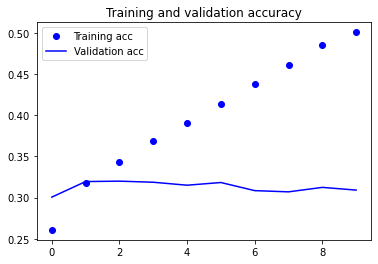

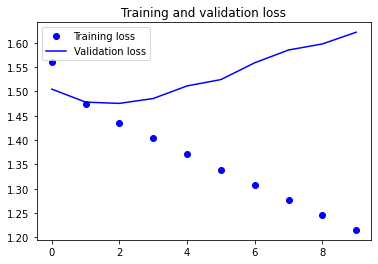

In [48]:
# Plot the Training and Validation Accuracy & Loss Scores

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# adding layers

In [49]:
# Build the Model

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length)) 
model.add(LSTM(32, return_sequences=True, recurrent_dropout=0.5))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(32))
model.add(Dense(5, activation='softmax'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 70, 64)            960000    
                                                                 
 lstm_2 (LSTM)               (None, 70, 32)            12416     
                                                                 
 lstm_3 (LSTM)               (None, 70, 32)            8320      
                                                                 
 lstm_4 (LSTM)               (None, 32)                8320      
                                                                 
 dense_5 (Dense)             (None, 5)                 165       
                                                                 
Total params: 989,221
Trainable params: 989,221
Non-trainable params: 0
_________________________________________________________________


In [50]:
# Train the Model
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/10
190/190 [==============================] - 19s 81ms/step - loss: 1.5827 - acc: 0.2428 - val_loss: 1.5407 - val_acc: 0.2701
Epoch 2/10
190/190 [==============================] - 16s 85ms/step - loss: 1.4881 - acc: 0.3025 - val_loss: 1.4809 - val_acc: 0.3210
Epoch 3/10
190/190 [==============================] - 16s 87ms/step - loss: 1.4498 - acc: 0.3247 - val_loss: 1.4762 - val_acc: 0.3180
Epoch 4/10
190/190 [==============================] - 16s 85ms/step - loss: 1.4172 - acc: 0.3526 - val_loss: 1.4848 - val_acc: 0.3218
Epoch 5/10
190/190 [==============================] - 17s 91ms/step - loss: 1.3856 - acc: 0.3766 - val_loss: 1.4970 - val_acc: 0.3128
Epoch 6/10
190/190 [==============================] - 17s 88ms/step - loss: 1.3557 - acc: 0.3990 - val_loss: 1.5110 - val_acc: 0.3088
Epoch 7/10
190/190 [==============================] - 17s 88ms/step - loss: 1.3262 - acc: 0.4159 - val_loss: 1.5594 - val_acc: 0.3088
Epoch 8/10
190/190 [==============================] - 16s 86ms

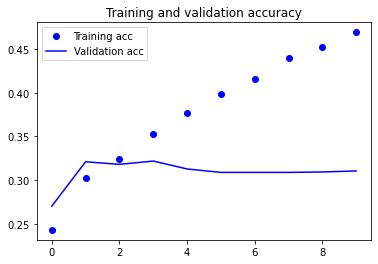

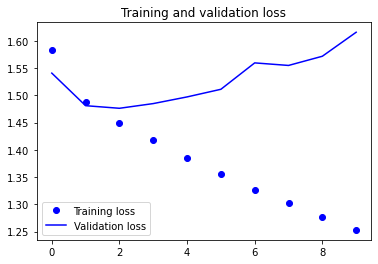

In [51]:
# Plot the Training and Validation Accuracy & Loss Scores

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# adding dropouts and recurrent dropouts to LSTM model

In [52]:
# Build the Model

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length)) 
model.add(Dropout(0.5))
model.add(LSTM(32, return_sequences=True, recurrent_dropout=0.5))
model.add(LSTM(32, return_sequences=True, recurrent_dropout=0.5))
model.add(LSTM(32))
model.add(Dense(5, activation='softmax'))
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 70, 64)            960000    
                                                                 
 dropout_1 (Dropout)         (None, 70, 64)            0         
                                                                 
 lstm_5 (LSTM)               (None, 70, 32)            12416     
                                                                 
 lstm_6 (LSTM)               (None, 70, 32)            8320      
                                                                 
 lstm_7 (LSTM)               (None, 32)                8320      
                                                                 
 dense_6 (Dense)             (None, 5)                 165       
                                                                 
Total params: 989,221
Trainable params: 989,221
Non-tr

In [53]:
# Train the Model
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/10
190/190 [==============================] - 20s 88ms/step - loss: 1.5907 - acc: 0.2359 - val_loss: 1.5363 - val_acc: 0.2777
Epoch 2/10
190/190 [==============================] - 18s 95ms/step - loss: 1.4994 - acc: 0.2952 - val_loss: 1.4875 - val_acc: 0.2869
Epoch 3/10
190/190 [==============================] - 18s 95ms/step - loss: 1.4684 - acc: 0.3159 - val_loss: 1.4776 - val_acc: 0.3014
Epoch 4/10
190/190 [==============================] - 18s 95ms/step - loss: 1.4475 - acc: 0.3316 - val_loss: 1.4724 - val_acc: 0.3146
Epoch 5/10
190/190 [==============================] - 18s 97ms/step - loss: 1.4315 - acc: 0.3440 - val_loss: 1.4792 - val_acc: 0.3128
Epoch 6/10
190/190 [==============================] - 18s 97ms/step - loss: 1.4120 - acc: 0.3562 - val_loss: 1.4866 - val_acc: 0.3047
Epoch 7/10
190/190 [==============================] - 18s 96ms/step - loss: 1.3956 - acc: 0.3704 - val_loss: 1.4978 - val_acc: 0.3236
Epoch 8/10
190/190 [==============================] - 18s 94ms

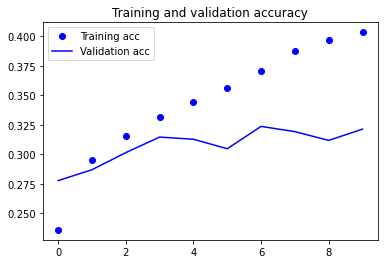

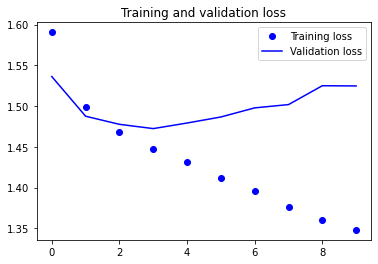

In [54]:
# Plot the Training and Validation Accuracy & Loss Scores

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
#it helped wiht the overfitting abit

In [ ]:
# adding more dropouts and adjusting parameters

In [55]:
# Build the Model

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length)) 
model.add(Dropout(0.6))
model.add(LSTM(64, return_sequences=True, recurrent_dropout=0.5))
model.add(Dropout(0.5))
model.add(LSTM(32, return_sequences=True, recurrent_dropout=0.5))
model.add(LSTM(32))
model.add(Dense(5, activation='softmax'))
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 70, 64)            960000    
                                                                 
 dropout_2 (Dropout)         (None, 70, 64)            0         
                                                                 
 lstm_8 (LSTM)               (None, 70, 64)            33024     
                                                                 
 dropout_3 (Dropout)         (None, 70, 64)            0         
                                                                 
 lstm_9 (LSTM)               (None, 70, 32)            12416     
                                                                 
 lstm_10 (LSTM)              (None, 32)                8320      
                                                                 
 dense_7 (Dense)             (None, 5)                

In [56]:
# Train the Model
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/10
190/190 [==============================] - 28s 125ms/step - loss: 1.5915 - acc: 0.2294 - val_loss: 1.5416 - val_acc: 0.2673
Epoch 2/10
190/190 [==============================] - 25s 132ms/step - loss: 1.5115 - acc: 0.2810 - val_loss: 1.4969 - val_acc: 0.3019
Epoch 3/10
190/190 [==============================] - 25s 132ms/step - loss: 1.4827 - acc: 0.3015 - val_loss: 1.4853 - val_acc: 0.2989
Epoch 4/10
190/190 [==============================] - 25s 132ms/step - loss: 1.4645 - acc: 0.3163 - val_loss: 1.4755 - val_acc: 0.3147
Epoch 5/10
190/190 [==============================] - 25s 132ms/step - loss: 1.4497 - acc: 0.3247 - val_loss: 1.4750 - val_acc: 0.3231
Epoch 6/10
190/190 [==============================] - 25s 133ms/step - loss: 1.4376 - acc: 0.3383 - val_loss: 1.4797 - val_acc: 0.3156
Epoch 7/10
190/190 [==============================] - 25s 131ms/step - loss: 1.4224 - acc: 0.3512 - val_loss: 1.4824 - val_acc: 0.3223
Epoch 8/10
190/190 [==============================] - 2

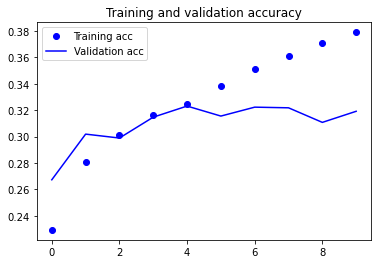

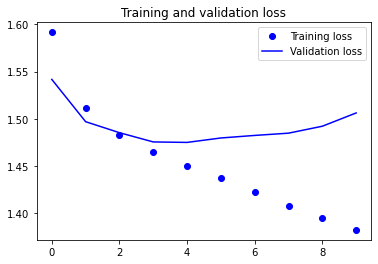

In [57]:
# Plot the Training and Validation Accuracy & Loss Scores

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
#adjusting dropouts and adding epochs

In [61]:
# Build the Model

l2_model = Sequential()
l2_model.add(Embedding(vocab_size, embedding_dim, input_length=max_length)) 
l2_model.add(Dropout(0.7))
l2_model.add(LSTM(32, return_sequences=True, recurrent_dropout=0.5))
l2_model.add(Dropout(0.7))
l2_model.add(LSTM(32, return_sequences=True, recurrent_dropout=0.5))
l2_model.add(LSTM(32))
l2_model.add(Dropout(0.7))
l2_model.add(Dense(5, activation='softmax'))
l2_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 70, 64)            960000    
                                                                 
 dropout_6 (Dropout)         (None, 70, 64)            0         
                                                                 
 lstm_14 (LSTM)              (None, 70, 32)            12416     
                                                                 
 dropout_7 (Dropout)         (None, 70, 32)            0         
                                                                 
 lstm_15 (LSTM)              (None, 70, 32)            8320      
                                                                 
 lstm_16 (LSTM)              (None, 32)                8320      
                                                                 
 dropout_8 (Dropout)         (None, 32)               

In [62]:
# Train the Model
l2_model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

history = l2_model.fit(X_train, y_train,
                    epochs=30,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/30
190/190 [==============================] - 23s 103ms/step - loss: 1.6098 - acc: 0.2047 - val_loss: 1.6081 - val_acc: 0.2058
Epoch 2/30
190/190 [==============================] - 21s 109ms/step - loss: 1.5945 - acc: 0.2373 - val_loss: 1.5616 - val_acc: 0.2854
Epoch 3/30
190/190 [==============================] - 21s 109ms/step - loss: 1.5447 - acc: 0.2722 - val_loss: 1.5108 - val_acc: 0.3012
Epoch 4/30
190/190 [==============================] - 21s 109ms/step - loss: 1.5127 - acc: 0.2906 - val_loss: 1.4944 - val_acc: 0.2979
Epoch 5/30
190/190 [==============================] - 21s 110ms/step - loss: 1.4992 - acc: 0.2971 - val_loss: 1.4843 - val_acc: 0.3121
Epoch 6/30
190/190 [==============================] - 21s 108ms/step - loss: 1.4886 - acc: 0.3039 - val_loss: 1.4800 - val_acc: 0.3240
Epoch 7/30
190/190 [==============================] - 21s 109ms/step - loss: 1.4816 - acc: 0.3076 - val_loss: 1.4756 - val_acc: 0.3175
Epoch 8/30
190/190 [==============================] - 2

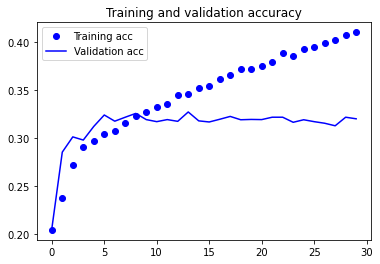

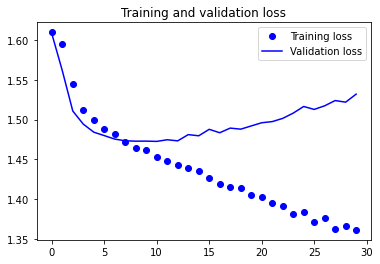

In [63]:
# Plot the Training and Validation Accuracy & Loss Scores

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
#adjusting dropouts and batch size
#removed l2 regularizer

In [67]:
# Build the Model

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length)) 
model.add(Dropout(0.7))
model.add(LSTM(32, return_sequences=True, recurrent_dropout=0.5))
model.add(Dropout(0.7))
model.add(LSTM(32, return_sequences=True, recurrent_dropout=0.5))
model.add(LSTM(32))
model.add(Dropout(0.7))
model.add(Dense(5, activation='softmax'))
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 70, 64)            960000    
                                                                 
 dropout_12 (Dropout)        (None, 70, 64)            0         
                                                                 
 lstm_20 (LSTM)              (None, 70, 32)            12416     
                                                                 
 dropout_13 (Dropout)        (None, 70, 32)            0         
                                                                 
 lstm_21 (LSTM)              (None, 70, 32)            8320      
                                                                 
 dropout_14 (Dropout)        (None, 70, 32)            0         
                                                                 
 lstm_22 (LSTM)              (None, 32)              

In [68]:
# Train the Model
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

history = model.fit(X_train, y_train,
                    epochs=30,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/30
190/190 [==============================] - 21s 91ms/step - loss: 1.6033 - acc: 0.2165 - val_loss: 1.5781 - val_acc: 0.2464
Epoch 2/30
190/190 [==============================] - 19s 101ms/step - loss: 1.5426 - acc: 0.2665 - val_loss: 1.5105 - val_acc: 0.3024
Epoch 3/30
190/190 [==============================] - 20s 103ms/step - loss: 1.5079 - acc: 0.2882 - val_loss: 1.4945 - val_acc: 0.2886
Epoch 4/30
190/190 [==============================] - 20s 104ms/step - loss: 1.4917 - acc: 0.2963 - val_loss: 1.4864 - val_acc: 0.3077
Epoch 5/30
190/190 [==============================] - 20s 103ms/step - loss: 1.4817 - acc: 0.3063 - val_loss: 1.4816 - val_acc: 0.3049
Epoch 6/30
190/190 [==============================] - 21s 113ms/step - loss: 1.4725 - acc: 0.3088 - val_loss: 1.4811 - val_acc: 0.3146
Epoch 7/30
190/190 [==============================] - 21s 111ms/step - loss: 1.4656 - acc: 0.3172 - val_loss: 1.4773 - val_acc: 0.2956
Epoch 8/30
190/190 [==============================] - 21

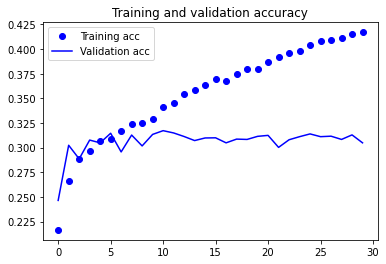

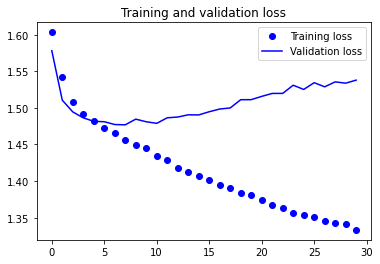

In [69]:
# Plot the Training and Validation Accuracy & Loss Scores

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
#adjusting dropouts

In [42]:
# Build the Model

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length)) 
model.add(Dropout(0.7))
model.add(LSTM(32, return_sequences=True))
model.add(Dropout(0.7))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(32))
model.add(Dense(5, activation='softmax'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 70, 64)            960000    
                                                                 
 dropout_8 (Dropout)         (None, 70, 64)            0         
                                                                 
 lstm_9 (LSTM)               (None, 70, 32)            12416     
                                                                 
 dropout_9 (Dropout)         (None, 70, 32)            0         
                                                                 
 lstm_10 (LSTM)              (None, 70, 32)            8320      
                                                                 
 lstm_11 (LSTM)              (None, 32)                8320      
                                                                 
 dense_3 (Dense)             (None, 5)                

In [43]:
# Train the Model
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

history = model.fit(X_train, y_train,
                    epochs=30,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/30
190/190 [==============================] - 18s 75ms/step - loss: 1.6025 - acc: 0.2203 - val_loss: 1.5739 - val_acc: 0.2825
Epoch 2/30
190/190 [==============================] - 14s 72ms/step - loss: 1.5343 - acc: 0.2813 - val_loss: 1.4996 - val_acc: 0.3086
Epoch 3/30
190/190 [==============================] - 15s 78ms/step - loss: 1.4949 - acc: 0.3009 - val_loss: 1.4827 - val_acc: 0.3137
Epoch 4/30
190/190 [==============================] - 15s 79ms/step - loss: 1.4784 - acc: 0.3079 - val_loss: 1.4795 - val_acc: 0.3035
Epoch 5/30
190/190 [==============================] - 14s 76ms/step - loss: 1.4640 - acc: 0.3215 - val_loss: 1.4716 - val_acc: 0.3179
Epoch 6/30
190/190 [==============================] - 14s 76ms/step - loss: 1.4517 - acc: 0.3319 - val_loss: 1.4778 - val_acc: 0.3113
Epoch 7/30
190/190 [==============================] - 16s 82ms/step - loss: 1.4424 - acc: 0.3380 - val_loss: 1.4737 - val_acc: 0.3091
Epoch 8/30
190/190 [==============================] - 16s 86ms

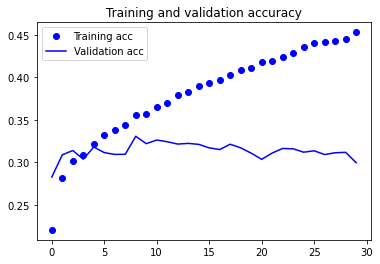

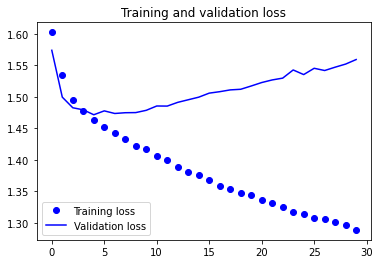

In [44]:
# Plot the Training and Validation Accuracy & Loss Scores

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [34]:
# Build the Model

l2_model = Sequential()
l2_model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
l2_model.add(Dropout(0.6))
l2_model.add(LSTM(32, return_sequences=True, recurrent_dropout=0.5))
l2_model.add(Dropout(0.5))
l2_model.add(LSTM(32, return_sequences=True, recurrent_dropout=0.5))
l2_model.add(Dropout(0.5))
l2_model.add(LSTM(32))
l2_model.add(Dense(5, activation='softmax'))
l2_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 70, 64)            960000    
                                                                 
 dropout (Dropout)           (None, 70, 64)            0         
                                                                 
 lstm (LSTM)                 (None, 70, 32)            12416     
                                                                 
 dropout_1 (Dropout)         (None, 70, 32)            0         
                                                                 
 lstm_1 (LSTM)               (None, 70, 32)            8320      
                                                                 
 dropout_2 (Dropout)         (None, 70, 32)            0         
                                                                 
 lstm_2 (LSTM)               (None, 32)                8

In [35]:
# Train the Model
l2_model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

history = l2_model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/10
190/190 [==============================] - 22s 99ms/step - loss: 1.6009 - acc: 0.2177 - val_loss: 1.5649 - val_acc: 0.2663
Epoch 2/10
190/190 [==============================] - 20s 106ms/step - loss: 1.5266 - acc: 0.2796 - val_loss: 1.5003 - val_acc: 0.2951
Epoch 3/10
190/190 [==============================] - 20s 105ms/step - loss: 1.4907 - acc: 0.3031 - val_loss: 1.4897 - val_acc: 0.3109
Epoch 4/10
190/190 [==============================] - 20s 105ms/step - loss: 1.4713 - acc: 0.3184 - val_loss: 1.4787 - val_acc: 0.3136
Epoch 5/10
190/190 [==============================] - 19s 101ms/step - loss: 1.4572 - acc: 0.3265 - val_loss: 1.4718 - val_acc: 0.3241
Epoch 6/10
190/190 [==============================] - 19s 102ms/step - loss: 1.4439 - acc: 0.3318 - val_loss: 1.4766 - val_acc: 0.3080
Epoch 7/10
190/190 [==============================] - 19s 103ms/step - loss: 1.4318 - acc: 0.3409 - val_loss: 1.4778 - val_acc: 0.3077
Epoch 8/10
190/190 [==============================] - 19

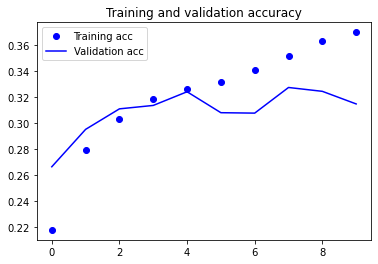

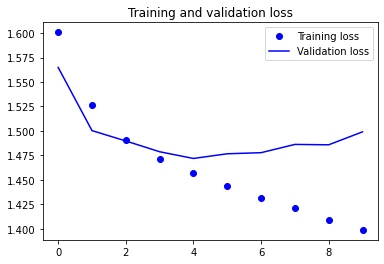

In [36]:
# Plot the Training and Validation Accuracy & Loss Scores

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [107]:
#Adjusting dropouts
# Build the Model

l2_model = Sequential()
l2_model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
l2_model.add(Dropout(0.55))
l2_model.add(LSTM(32, return_sequences=True, recurrent_dropout=0.5))
l2_model.add(Dropout(0.6))
l2_model.add(LSTM(32, return_sequences=True, recurrent_dropout=0.5))
l2_model.add(Dropout(0.65))
l2_model.add(LSTM(32))
l2_model.add(Dense(5, activation='softmax'))
l2_model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_24 (Embedding)    (None, 70, 64)            960000    
                                                                 
 dropout_80 (Dropout)        (None, 70, 64)            0         
                                                                 
 lstm_64 (LSTM)              (None, 70, 32)            12416     
                                                                 
 dropout_81 (Dropout)        (None, 70, 32)            0         
                                                                 
 lstm_65 (LSTM)              (None, 70, 32)            8320      
                                                                 
 dropout_82 (Dropout)        (None, 70, 32)            0         
                                                                 
 lstm_66 (LSTM)              (None, 32)              

In [108]:
# Train the Model
l2_model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

history = l2_model.fit(X_train, y_train,
                    epochs=30,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/30
190/190 [==============================] - 27s 118ms/step - loss: 1.6060 - acc: 0.2204 - val_loss: 1.5862 - val_acc: 0.2372
Epoch 2/30
190/190 [==============================] - 24s 128ms/step - loss: 1.5425 - acc: 0.2712 - val_loss: 1.5104 - val_acc: 0.2795
Epoch 3/30
190/190 [==============================] - 24s 129ms/step - loss: 1.4980 - acc: 0.2970 - val_loss: 1.4853 - val_acc: 0.3149
Epoch 4/30
190/190 [==============================] - 24s 127ms/step - loss: 1.4757 - acc: 0.3118 - val_loss: 1.4786 - val_acc: 0.3187
Epoch 5/30
190/190 [==============================] - 24s 129ms/step - loss: 1.4613 - acc: 0.3227 - val_loss: 1.4751 - val_acc: 0.3175
Epoch 6/30
190/190 [==============================] - 24s 128ms/step - loss: 1.4477 - acc: 0.3318 - val_loss: 1.4762 - val_acc: 0.3160
Epoch 7/30
190/190 [==============================] - 25s 129ms/step - loss: 1.4365 - acc: 0.3433 - val_loss: 1.4769 - val_acc: 0.3208
Epoch 8/30
190/190 [==============================] - 2

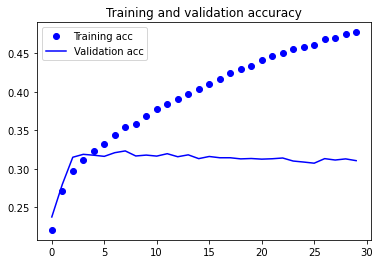

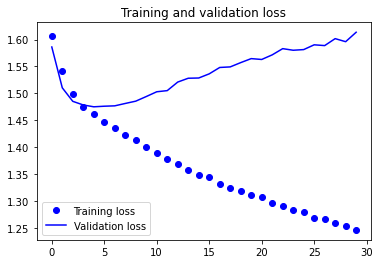

In [109]:
# Plot the Training and Validation Accuracy & Loss Scores

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [38]:
# Save the Model
l2_model.save('best_model_cj.h5')

### Model #2  (Student Name: XXXX)

In [47]:
# Build the Model


In [48]:
# Train the Model


In [49]:
# Plot the Training and Validation Accuracy & Loss Scores


### Model #3  (Student Name: XXXX)

In [50]:
# Build the Model


In [51]:
# Train the Model


In [52]:
# Plot the Training and Validation Accuracy & Loss Scores


In [53]:
# Save the Model
model.save('text_model_2.h5')

### Model #4  (Student Name: XXXX)

In [54]:
# Build the Model


In [55]:
# Train the Model


In [56]:
# Plot the Training and Validation Accuracy & Loss Scores


In [57]:
# Save the Model
model.save('text_model_2.h5')

### Model #5  (Student Name: XXXX)

In [58]:
# Build the Model


In [59]:
# Train the Model


In [60]:
# Plot the Training and Validation Accuracy & Loss Scores


In [61]:
# Save the Model
model.save('text_model_2.h5')

## Step 3 – Evaluate the Model using Testing Data (Individual & Group)

Exporting the Temple Run Dataset into a csv file

In [5]:
templerun_dataset = df[['content_final', 'score']]
templerun_dataset.to_csv("templerun_dataset.csv", index=False)

KeyError: "['content_final'] not in index"

# 3.1 Standardizing the datasets

1. Standardizing the Snapchat dataset

In [46]:
snapchat_dataset = pd.read_csv("snapchat_dataset.csv")
def strings(text):
    text = str(text)
    return text

snapchat_dataset['content_final'] = snapchat_dataset['content_final'].apply(lambda x:strings(x))
snapchat_dataset

,content_final,score
0,best apps,0
1,lag,0
2,adnan,0
3,have install snapchat a day snapchat se 1 mess...,0
4,pic qwality low,0
...,...,...
37922,muzmlekana,4
37923,ok,4
37924,is nice app,4
37925,superb,4


In [47]:
#Param for tokenizing and padding

X_snapchat = snapchat_dataset['content_final']
y_snapchat = snapchat_dataset['score']


#training sequence and labels
snapchat_train_seqs = tokenizer.texts_to_sequences(snapchat_dataset['content_final'])
snapchat_train_padded = pad_sequences(snapchat_train_seqs, maxlen=max_length, truncating=trunc_type, padding= "pre")
X_train_snapchat, X_test_snapchat, y_train_snapchat, y_test_snapchat = train_test_split(snapchat_train_padded, y_snapchat, test_size=0.2, random_state=42)

In [48]:
model = keras.models.load_model("best_model_cj.h5")
model.evaluate(X_test_snapchat, y_test_snapchat, batch_size=32)

238/238 [==============================] - 4s 13ms/step - loss: 2.7273 - acc: 0.2571


[2.7273330688476562, 0.2570524513721466]

2. Standardizing the Disney+ dataset

In [49]:
disney_dataset = pd.read_csv("disney_dataset.csv")
def strings(text):
    text = str(text)
    return text

disney_dataset['content_final'] = disney_dataset['content_final'].apply(lambda x:strings(x))
disney_dataset

,content_final,score
0,problem until 4 month ago no matter solution t...,0
1,cant launch application the update cannot use ...,0
2,app never work properly lag like crazy dont re...,0
3,keep crashing freezing downloads,0
4,do want like but app refuse load since 3rd epi...,0
...,...,...
38850,favorite my childrens favorite,4
38851,different movie ever go i can which movie fami...,4
38852,perfect channel watch great movie specifically...,4
38853,great app adult child,4


In [50]:
#Param for tokenizing and padding

X_disney = disney_dataset['content_final']
y_disney = disney_dataset['score']


#training sequence and labels
disney_train_seqs = tokenizer.texts_to_sequences(disney_dataset['content_final'])
disney_train_padded = pad_sequences(disney_train_seqs, maxlen=max_length, truncating=trunc_type, padding= "pre")
X_train_disney, X_test_disney, y_train_disney, y_test_disney = train_test_split(disney_train_padded, y_disney, test_size=0.2, random_state=42)

In [51]:
model = keras.models.load_model("best_model_cj.h5")
model.evaluate(X_test_disney, y_test_disney, batch_size=32)

243/243 [==============================] - 4s 13ms/step - loss: 3.2359 - acc: 0.2575


[3.2358860969543457, 0.25749582052230835]

3. Standardizing the Facebook dataset

In [52]:
facebook_dataset = pd.read_csv("facebook_dataset.csv")
def strings(text):
    text = str(text)
    return text

facebook_dataset['content_final'] = facebook_dataset['content_final'].apply(lambda x:strings(x))
facebook_dataset

,content_final,score
0,is amazing,0
1,nice,0
2,facebook doch chkea crash lhot,0
3,bjw ව ව ද ඹ ව ව w w,0
4,is app authentication code generate,0
...,...,...
39993,good,4
39994,wusihclzh,4
39995,nice,4
39996,excellent experience,4


In [53]:
#Param for tokenizing and padding

X_facebook = facebook_dataset['content_final']
y_facebook = facebook_dataset['score']


#training sequence and labels
facebook_train_seqs = tokenizer.texts_to_sequences(facebook_dataset['content_final'])
facebook_train_padded = pad_sequences(facebook_train_seqs, maxlen=max_length, truncating=trunc_type, padding= "pre")
X_train_facebook, X_test_facebook, y_train_facebook, y_test_facebook = train_test_split(facebook_train_padded, y_facebook, test_size=0.2, random_state=42)

In [54]:
model = keras.models.load_model("best_model_cj.h5")
model.evaluate(X_test_facebook, y_test_facebook, batch_size=32)

250/250 [==============================] - 4s 13ms/step - loss: 2.9224 - acc: 0.2294


[2.9223594665527344, 0.22937500476837158]

4. Standardizing the Instagram dataset

In [55]:
instagram_dataset = pd.read_csv("instagram_dataset.csv")
def strings(text):
    text = str(text)
    return text

instagram_dataset['content_final'] = instagram_dataset['content_final'].apply(lambda x:strings(x))
instagram_dataset

,content_final,score
0,app not opening update many uninstalls install...,0
1,super ok,0
2,cant install instagram app have tried for past...,0
3,is time wasting app me,0
4,app not working sir plz fix cant open instagra...,0
...,...,...
38207,happy life,4
38208,nice app,4
38209,love insta revolvinghearts,4
38210,is vrey op aap please downlod try app,4


In [56]:
#Param for tokenizing and padding

X_instagram = instagram_dataset['content_final']
y_instagram = instagram_dataset['score']


#training sequence and labels
instagram_train_seqs = tokenizer.texts_to_sequences(instagram_dataset['content_final'])
instagram_train_padded = pad_sequences(instagram_train_seqs, maxlen=max_length, truncating=trunc_type, padding= "pre")
X_train_instagram, X_test_instagram, y_train_instagram, y_test_instagram = train_test_split(instagram_train_padded, y_instagram, test_size=0.2, random_state=42)

In [57]:
model = keras.models.load_model("best_model_cj.h5")
model.evaluate(X_test_instagram, y_test_instagram, batch_size=32)

239/239 [==============================] - 4s 13ms/step - loss: 2.7575 - acc: 0.2534


[2.757539987564087, 0.25343450903892517]

In [67]:
templerun_dataset = pd.read_csv("templerun_dataset.csv")
def strings(text):
    text = str(text)
    return text

templerun_dataset['content_final'] = templerun_dataset['content_final'].apply(lambda x:strings(x))
templerun_dataset

,content_final,score
0,thanks,0
1,good game,0
2,is super game,0
3,fing game,0
4,good morning baby girl,0
...,...,...
37960,ganesh o,4
37961,because is wonderful,4
37962,favorite game a kid,4
37963,best game ever milkyway,4


In [69]:
#Param for tokenizing and padding

X_templerun = templerun_dataset['content_final']
y_templerun = templerun_dataset['score']


#training sequence and labels
templerun_train_seqs = tokenizer.texts_to_sequences(templerun_dataset['content_final'])
templerun_train_padded = pad_sequences(templerun_train_seqs, maxlen=max_length, truncating=trunc_type, padding= "pre")
X_train_templerun, X_test_templerun, y_train_templerun, y_test_templerun = train_test_split(templerun_train_padded, y_templerun, test_size=0.2, random_state=42)

# 3.2 Evaluating the test accuracies for the Temple Run model across all 5 datasets

In [58]:
model = keras.models.load_model("best_model_cj.h5")

In [61]:
print("[Temple Run Model] Test accuracy of Facebook dataset: ")
model.evaluate(X_test_facebook, y_test_facebook)

[Temple Run Model] Test accuracy of Facebook dataset: 
250/250 [==============================] - 4s 13ms/step - loss: 2.9224 - acc: 0.2294


[2.9223594665527344, 0.22937500476837158]

In [63]:
print("[Temple Run Model] Test accuracy of Instagram dataset: ")
model.evaluate(X_test_instagram, y_test_instagram)

[Temple Run Model] Test accuracy of Instagram dataset: 
239/239 [==============================] - 5s 13ms/step - loss: 2.7575 - acc: 0.2534


[2.757539987564087, 0.25343450903892517]

In [64]:
print("[Temple Run Model] Test accuracy of Snapchat dataset: ")
model.evaluate(X_test_snapchat, y_test_snapchat)

[Temple Run Model] Test accuracy of Snapchat dataset: 
238/238 [==============================] - 3s 13ms/step - loss: 2.7273 - acc: 0.2571


[2.7273330688476562, 0.2570524513721466]

In [65]:
print("[Temple Run Model] Test accuracy of Disney+ dataset: ")
model.evaluate(X_test_disney, y_test_disney)

[Temple Run Model] Test accuracy of Disney+ dataset: 
243/243 [==============================] - 3s 13ms/step - loss: 3.2359 - acc: 0.2575


[3.2358860969543457, 0.25749582052230835]

In [70]:
print("[Temple Run Model] Test accuracy of Temple Run dataset: ")
model.evaluate(X_test_templerun, y_test_templerun)

[Temple Run Model] Test accuracy of Temple Run dataset: 
238/238 [==============================] - 3s 13ms/step - loss: 1.4959 - acc: 0.3207


[1.4959301948547363, 0.3206900954246521]

In [ ]:
# Save the Best Model
model.save('text_model_best.h5')

## Step 4 – Use the Best Model to make prediction (Group)

In [ ]:
best_model = keras.models.load_model('text_model_best.h5')

In [ ]:
# takes the user input
text_input = np.array([input()])

In [ ]:
# convert the user input into numeric tensor


In [ ]:
# show the model output using predict function

